In [10]:
import pandas as pd

data = pd.read_csv('~/ctgan/data/annualized_SD_p5_std.csv')
data.head()

,Annual Avg Yield,Annual Avg Min Temp,Annual Avg Max Temp,Total Accumulated Rain,Total Accumulated Radiation,Class
0,1.615000,3.607579,16.450760,4320.03,589529.46,1
1,1.580000,2.977617,15.747898,5426.99,762918.99,1
2,1.223333,3.016332,15.804588,5420.95,1083330.58,0
3,1.497500,3.607579,16.450760,4320.03,589529.46,1
4,1.640000,2.977617,15.747898,5426.99,762918.99,1


In [11]:
from sdv.tabular import TVAE

model = TVAE()
model.fit(data)

In [12]:
new_data = model.sample(5000)

In [13]:
new_data.to_csv('~/ctgan/data/synthData/xgb_1106_5k_snlt_sd_ann2oh8_tvae1.csv')
new_data.head()

,Annual Avg Yield,Annual Avg Min Temp,Annual Avg Max Temp,Total Accumulated Rain,Total Accumulated Radiation,Class
0,1.412025,1.450485,13.834746,2713.40,510824.0,1
1,1.579296,2.429029,15.186553,5792.43,1082256.0,2
2,1.136685,2.793762,13.955866,2814.94,449752.0,0
3,1.124654,3.341859,16.611482,5251.43,1102683.0,0
4,1.205800,3.007872,16.539362,3293.99,498618.0,1


In [14]:
# get aggregate data
targetDataLoc = '~/ctgan/data/annualized_OH_p5_std_1varPerYear_8.csv'
#aggDataLoc = 'data/synth1_GA_only_063022.csv'

aggDf = new_data #pd.read_csv(aggDataLoc)
#aggDf = aggDf.drop("Unnamed: 0",axis=1)
targetDf = pd.read_csv(targetDataLoc)
#targetDf = targetDf.drop("Unnamed: 0",axis=1)

In [15]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neighbors import KNeighborsClassifier # k-nearest neightbors for classification
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor # adaboost for regression
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [16]:
# filter out the features that will not be used by the machine learning models

# the features to keep:
# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Time Since Last Harvest (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)", "Day Length (hrs)"], "Percent Cover (%)"]

# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)"]

xColumnsToKeep = ["Total Accumulated Radiation","Total Accumulated Rain", "Annual Avg Max Temp", "Annual Avg Min Temp"]


#xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)", "Total Rainfall (mm)"]

# the target to keep
yColumnsToKeep = ["Class"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [17]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["gini"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['gini'],
    'model__max_depth': [5,10,25,50,100]
    }

xgbParamGrid = {
    #'tree_method': ["gpu_hist"], 
    #'enable_categorical': [True], 
    #'use_label_encoder': [False]
}

aModelList = [#(RandomForestClassifier(), rfParamGrid, "rfTup.pkl"),
              #(KNeighborsClassifier(), knnParamGrid, "knnTup.pkl"),
              #(SVC(), svrParamGrid, "svrTup.pkl"),
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             #(LogisticRegression(), linRegParamGrid, "linRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeClassifier(), dtParamGrid, "dtTup.pkl")]
             (xgb.XGBClassifier(), xgbParamGrid, "xgbTup1106.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  xgbTup1106
Avg MAE:  745.2
Avg R squared:  -0.224
Best MAE:  656.0
Best R squared:  -0.038
Parameters of the best model:  {}
Features selected by best model:  ['Total Accumulated Radiation', 'Total Accumulated Rain', 'Annual Avg Max Temp', 'Annual Avg Min Temp']
Accuracy:  0.67
f1 score:  0.5654908574015666
mcc:  0.3631797102069461
 
test results on our test data: 


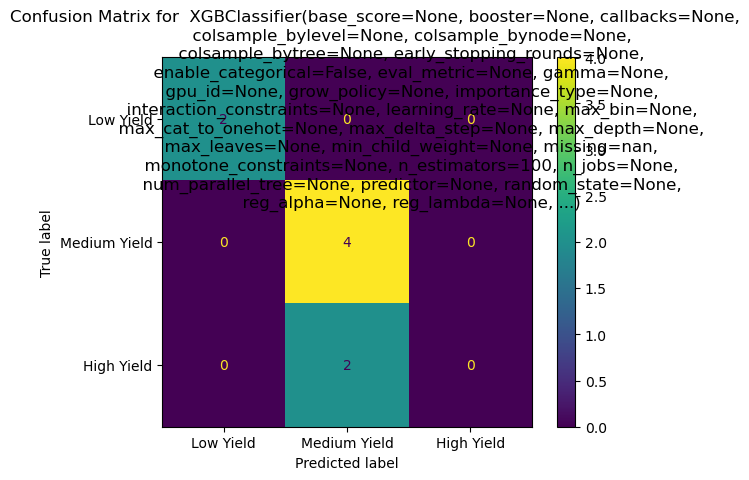

results:
MAE:  0.25
R sq:  0.5
accuracy score for DA/TDA:  0.75


In [18]:
saveMLResults(test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)